# Exploratory Spatio-Temporal Data Analysis
# Part 1 - Data Inspection and Descriptive Statistics - Summary Statistics

In [19]:
import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [20]:
import xarray as xr 

# ds = xr.open_dataset('/teamspace/studios/this_studio/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/merged_data.nc'')
ds = xr.open_dataset('/Users/adamprzychodni/Documents/Repos/ml-drought-forecasting/ml-modeling-pipeline/data/02_intermediate/merged_data.nc')

In [21]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:    (date: 276, latitude: 61, longitude: 360)
Coordinates:
  * date       (date) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2022-12-01
  * latitude   (latitude) float64 488B -30.0 -29.0 -28.0 ... 28.0 29.0 30.0
  * longitude  (longitude) int64 3kB -180 -179 -178 -177 ... 176 177 178 179
    number     int64 8B ...
    expver     (date) <U4 4kB ...
Data variables: (12/21)
    t2m        (date, latitude, longitude) float64 48MB ...
    d2m        (date, latitude, longitude) float64 48MB ...
    msl        (date, latitude, longitude) float64 48MB ...
    sp         (date, latitude, longitude) float64 48MB ...
    sst        (date, latitude, longitude) float64 48MB ...
    skt        (date, latitude, longitude) float64 48MB ...
    ...         ...
    cvl        (date, latitude, longitude) float64 48MB ...
    tcc        (date, latitude, longitude) float64 48MB ...
    mper       (date, latitude, longitude) float64 48MB ...
    tco3       (date, latitude, longitude) float64 48MB ...
    lsm        (date, latitude, longitude) float64 48MB ...
    sm         (date, latitude, longitude) float64 48MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-17T18:05 GRIB to CDM+CF via cfgrib-0.9.1...

## Data Inspection

### Area of intrest

In [48]:
from typing import Optional
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

def visualize_variable_on_map(
    dataset: xr.Dataset,
    variable: str,
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    projection: str = 'natural earth',
    color_scale: str = 'Viridis',
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
) -> go.Figure:
    # Convert DataArray to DataFrame
    da = dataset[variable]
    df = da.to_dataframe().reset_index()

    # Drop NaNs
    df = df.dropna(subset=[variable])

    # Handle animation frame
    if animation_frame:
        df[animation_frame] = df[animation_frame].astype(str)
    else:
        df['Frame'] = 'Frame'
    
    # Create scatter_geo plot
    fig = px.scatter_geo(
        df,
        lat=lat_dim,
        lon=lon_dim,
        color=variable,
        animation_frame=animation_frame if animation_frame else 'Frame',
        projection=projection,
        color_continuous_scale=color_scale,
        title=title,
        labels={variable: variable.upper()},
        hover_data={variable: f':.{hover_precision}f'},
    )
    
    # Add Play/Pause buttons
    fig.update_layout(
        updatemenus=[dict(
            type='buttons',
            buttons=[
                dict(label='Play',
                     method='animate',
                     args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
                dict(label='Pause',
                     method='animate',
                     args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
            ],
            showactive=False,
            x=0.1,
            y=0
        )]
    )

    return fig


In [61]:
# # Example usage:
# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable='sm',
#     lat_dim='latitude',
#     lon_dim='longitude',
#     animation_frame='date',
#     title='Soil Moisture Over Time',
#     color_scale = [
#         [0.0, "darkred"],
#         [0.1, "red"],
#         [0.2, "orangered"],
#         [0.3, "lightgreen"],
#         [0.4, "limegreen"],
#         [0.5, "green"],
#         [0.55, "darkseagreen"],
#         [0.6, "darkgreen"],
#         [0.7, "lightblue"],
#         [0.8, "skyblue"],
#         [0.9, "deepskyblue"],
#         [1.0, "blue"]
#     ]
# )
# fig.show()

In [62]:
# # Example usage:
# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable='swvl1',
#     lat_dim='latitude',
#     lon_dim='longitude',
#     animation_frame='date',
#     title='2M Temperature Over Time',
#     color_scale = [
#         [0.0, "darkred"],
#         [0.1, "red"],
#         [0.2, "orangered"],
#         [0.3, "lightgreen"],
#         [0.4, "limegreen"],
#         [0.5, "green"],
#         [0.55, "darkseagreen"],
#         [0.6, "darkgreen"],
#         [0.7, "lightblue"],
#         [0.8, "skyblue"],
#         [0.9, "deepskyblue"],
#         [1.0, "blue"]
#     ]
# )
# fig.show()

In [6]:
# Convert the xarray Dataset to a pandas DataFrame
df_pandas = ds.to_dataframe().reset_index()

# Convert the pandas DataFrame to a Polars DataFrame
polars_df = pl.from_pandas(df_pandas)

# Display the Polars DataFrame
polars_df

date,latitude,longitude,t2m,d2m,msl,sp,sst,skt,e,pev,mlspr,ro,slt,swvl1,stl1,cvh,lai_hv,cvl,tcc,mper,tco3,lsm,sm,number,expver
datetime[ns],f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
2000-01-01 00:00:00,-30.0,-180,294.796997,291.070618,101160.6875,101161.835938,295.600098,295.490356,-0.002701,7.8231e-8,0.000019,0.0,0.0,-0.000004,295.601257,0.0,0.0,0.0,0.700278,-1.1933e-9,0.005651,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-179,294.720825,290.95343,101172.6875,101170.835938,295.467285,295.334106,-0.002745,7.8231e-8,0.000018,0.0,0.0,-0.000004,295.468445,0.0,0.0,0.0,0.691687,-1.1933e-9,0.005647,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-178,294.691528,290.701477,101184.8125,101183.835938,295.26709,295.132935,-0.002674,7.8231e-8,0.000023,0.0,0.0,-0.000004,295.267273,0.0,0.0,0.0,0.69158,-1.1933e-9,0.005646,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-177,294.933716,290.498352,101193.1875,101192.835938,295.914551,295.730591,-0.003307,7.8231e-8,0.000022,0.0,0.0,-0.000004,295.91571,0.0,0.0,0.0,0.722647,-1.1933e-9,0.005647,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-176,294.988403,290.291321,101201.1875,101200.835938,296.134277,295.931763,-0.003642,7.8231e-8,0.000032,0.0,0.0,-0.000004,296.13446,0.0,0.0,0.0,0.726248,-1.1933e-9,0.005652,0.0,2.0,0,"""0001"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-12-01 00:00:00,30.0,175,293.001068,287.841431,101574.3125,101572.875,294.701172,294.51001,-0.006095,-1.4901e-8,0.000029,0.0,0.0,-0.000005,294.70166,0.0,0.0,0.0,0.659524,-2.7212e-9,0.005557,0.0,2.0,0,"""0001"""
2022-12-01 00:00:00,30.0,176,292.954193,287.835571,101553.3125,101553.875,294.519531,294.338135,-0.005904,-1.4901e-8,0.000029,0.0,0.0,-0.000005,294.52002,0.0,0.0,0.0,0.646615,-2.7212e-9,0.005581,0.0,2.0,0,"""0001"""
2022-12-01 00:00:00,30.0,177,293.079193,287.925415,101529.8125,101530.875,294.989258,294.789307,-0.006563,-1.4901e-8,0.000029,0.0,0.0,-0.000005,294.98877,0.0,0.0,0.0,0.634698,-2.7212e-9,0.005606,0.0,2.0,0,"""0001"""


In [7]:
polars_df

date,latitude,longitude,t2m,d2m,msl,sp,sst,skt,e,pev,mlspr,ro,slt,swvl1,stl1,cvh,lai_hv,cvl,tcc,mper,tco3,lsm,sm,number,expver
datetime[ns],f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
2000-01-01 00:00:00,-30.0,-180,294.796997,291.070618,101160.6875,101161.835938,295.600098,295.490356,-0.002701,7.8231e-8,0.000019,0.0,0.0,-0.000004,295.601257,0.0,0.0,0.0,0.700278,-1.1933e-9,0.005651,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-179,294.720825,290.95343,101172.6875,101170.835938,295.467285,295.334106,-0.002745,7.8231e-8,0.000018,0.0,0.0,-0.000004,295.468445,0.0,0.0,0.0,0.691687,-1.1933e-9,0.005647,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-178,294.691528,290.701477,101184.8125,101183.835938,295.26709,295.132935,-0.002674,7.8231e-8,0.000023,0.0,0.0,-0.000004,295.267273,0.0,0.0,0.0,0.69158,-1.1933e-9,0.005646,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-177,294.933716,290.498352,101193.1875,101192.835938,295.914551,295.730591,-0.003307,7.8231e-8,0.000022,0.0,0.0,-0.000004,295.91571,0.0,0.0,0.0,0.722647,-1.1933e-9,0.005647,0.0,2.0,0,"""0001"""
2000-01-01 00:00:00,-30.0,-176,294.988403,290.291321,101201.1875,101200.835938,296.134277,295.931763,-0.003642,7.8231e-8,0.000032,0.0,0.0,-0.000004,296.13446,0.0,0.0,0.0,0.726248,-1.1933e-9,0.005652,0.0,2.0,0,"""0001"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2022-12-01 00:00:00,30.0,175,293.001068,287.841431,101574.3125,101572.875,294.701172,294.51001,-0.006095,-1.4901e-8,0.000029,0.0,0.0,-0.000005,294.70166,0.0,0.0,0.0,0.659524,-2.7212e-9,0.005557,0.0,2.0,0,"""0001"""
2022-12-01 00:00:00,30.0,176,292.954193,287.835571,101553.3125,101553.875,294.519531,294.338135,-0.005904,-1.4901e-8,0.000029,0.0,0.0,-0.000005,294.52002,0.0,0.0,0.0,0.646615,-2.7212e-9,0.005581,0.0,2.0,0,"""0001"""
2022-12-01 00:00:00,30.0,177,293.079193,287.925415,101529.8125,101530.875,294.989258,294.789307,-0.006563,-1.4901e-8,0.000029,0.0,0.0,-0.000005,294.98877,0.0,0.0,0.0,0.634698,-2.7212e-9,0.005606,0.0,2.0,0,"""0001"""


### Missing values

In [19]:
def calculate_missing_percentages(df: pl.DataFrame, missing_value: float = None) -> pl.DataFrame:
    """
    Calculates the percentage of missing values in each column of a Polars DataFrame, 
    considering a specified missing value.

    Parameters:
    - df (pl.DataFrame): The input DataFrame with potentially missing values.
    - missing_value (float, optional): A custom value to treat as missing. Default is None, which means only None values are considered missing.

    Returns:
    - pl.DataFrame: A DataFrame with one row showing the percentage of missing values for each column.
    """
    total_rows = df.height  # Access the number of rows in the DataFrame
    if missing_value is not None:
        # Create a condition for custom missing value and None
        missing_condition = lambda column: (pl.col(column).is_null() | (pl.col(column) == missing_value)).sum().alias(column)
    else:
        # Default condition if no custom missing value provided
        missing_condition = lambda column: pl.col(column).is_null().sum().alias(column)
    
    missing_counts = df.select([missing_condition(column) for column in df.columns])
    missing_percentage = missing_counts / total_rows * 100
    
    return missing_percentage

# Example usage
# missing_percentages = calculate_missing_percentages(polars_df)
# missing_percentages


In [20]:
missing_percentages = calculate_missing_percentages(polars_df)
missing_percentages


lat,lon,time,T2M,T2M_MAX,T2M_MIN,TS,PS,WS2M,WS10M,WS50M,QV2M,QV10M,RH2M,TQV,T2MDEW,T2MWET,DISPH,RHOA,TO3,TROPPB,TROPQ,TROPT,U10M,U2M,U50M,V10M,V2M,V50M,WD10M,WD2M,WD50M,eddi_01mn,eddi_01wk,eddi_02mn,eddi_02wk,eddi_03mn,eddi_06mn,eddi_09mn,eddi_12mn,Nino12,Nino3,Nino34,Nino4,WTIO,SETIO,DMI,SWIO,PRECTOTCORR_mm,eddi_01mn_category_encoded,eddi_01wk_category_encoded,eddi_02mn_category_encoded,eddi_02wk_category_encoded,eddi_03mn_category_encoded,eddi_06mn_category_encoded,eddi_09mn_category_encoded,eddi_12mn_category_encoded,id
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Example usage
missing_percentages = calculate_missing_percentages(polars_df, -999.0)
missing_percentages

lat,lon,time,T2M,T2M_MAX,T2M_MIN,TS,PS,WS2M,WS10M,WS50M,QV2M,QV10M,RH2M,TQV,T2MDEW,T2MWET,DISPH,RHOA,TO3,TROPPB,TROPQ,TROPT,U10M,U2M,U50M,V10M,V2M,V50M,WD10M,WD2M,WD50M,eddi_01mn,eddi_01wk,eddi_02mn,eddi_02wk,eddi_03mn,eddi_06mn,eddi_09mn,eddi_12mn,Nino12,Nino3,Nino34,Nino4,WTIO,SETIO,DMI,SWIO,PRECTOTCORR_mm,eddi_01mn_category_encoded,eddi_01wk_category_encoded,eddi_02mn_category_encoded,eddi_02wk_category_encoded,eddi_03mn_category_encoded,eddi_06mn_category_encoded,eddi_09mn_category_encoded,eddi_12mn_category_encoded,id
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Descriptive statistics

### Summmary statistics

In [22]:
summary_stats_polars = polars_df.describe()
summary_stats_polars

statistic,lat,lon,time,T2M,T2M_MAX,T2M_MIN,TS,PS,WS2M,WS10M,WS50M,QV2M,QV10M,RH2M,TQV,T2MDEW,T2MWET,DISPH,RHOA,TO3,TROPPB,TROPQ,TROPT,U10M,U2M,U50M,V10M,V2M,V50M,WD10M,WD2M,WD50M,eddi_01mn,eddi_01wk,eddi_02mn,eddi_02wk,eddi_03mn,eddi_06mn,eddi_09mn,eddi_12mn,Nino12,Nino3,Nino34,Nino4,WTIO,SETIO,DMI,SWIO,PRECTOTCORR_mm,eddi_01mn_category_encoded,eddi_01wk_category_encoded,eddi_02mn_category_encoded,eddi_02wk_category_encoded,eddi_03mn_category_encoded,eddi_06mn_category_encoded,eddi_09mn_category_encoded,eddi_12mn_category_encoded,id
str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3.65064e6,3.65064e6,"""3650640""",3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6,3.65064e6
"""null_count""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",7.370122,35.121189,"""2003-01-01""",25.25371,32.065718,19.313322,299.768522,92531.379175,2.881049,4.014844,5.577802,0.010685,0.010422,52.32437,29.188162,285.299865,291.851788,0.685543,1.075016,259.717596,10372.106874,0.000001,193.439853,-1.261934,-0.888067,-1.777766,0.037046,0.019344,-0.04406,139.222758,139.277888,138.717962,0.028506,0.020179,0.032187,0.023849,0.033605,0.038189,0.04407,0.04972,0.0819,0.054867,0.032902,0.085233,-0.053805,-0.041671,-0.012133,-0.032258,1.861758,-0.091757,-0.06551,-0.104991,-0.076026,-0.111475,-0.129507,-0.151749,-0.170934,819.5
"""std""",8.246206,6.043982,null,4.719548,5.151317,4.650905,5.224984,5279.636721,1.321278,1.600339,1.976779,0.004201,0.00405,21.628866,11.495585,7.637245,4.728372,2.176623,0.054293,11.925479,796.470126,0.000002,2.631952,2.273882,1.68315,3.05688,2.937832,2.170559,4.020097,58.365959,58.388658,58.256427,0.948069,0.878496,0.9558,0.926623,0.957712,0.957227,0.959246,0.95705,1.134049,0.926957,0.891409,0.692181,0.454532,0.475697,0.532017,0.477768,3.494411,3.278199,3.163183,3.287684,3.246293,3.290297,3.288717,3.29104,3.286435,473.427198
"""min""",-11.5,23.125,"""1981-09-06""",5.637946,13.201563,-1.03058,278.940848,72296.517857,0.0,0.501116,0.907366,0.001264,0.001264,5.732143,1.987723,258.610491,272.188616,0.0,0.872489,210.810268,7783.125,0.0,183.055804,-9.417411,-7.617188,-11.324777,-8.601562,-7.476562,-10.8125,9.6875,9.669643,10.169643,-2.167536,-2.167536,-2.167536,-2.167536,-2.167536,-2.167536,-2.167536,-2.167536,-2.429724,-2.362384,-2.388773,-1.957877,-1.307856,-1.915855,-1.726229,-1.701713,0.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,0.0
"""25%""",1.5,30.625,"""1992-05-03""",22.194866,28.479464,16.360045,296.340402,89081.035714,1.885045,2.803571,4.043527,0.007647,0.007481,35.098214,20.132812,281.058036,289.225446,0.078125,1.040039,250.996652,9866.366071,0.0,191.591518,-2.799107,-1.981027,-3.972098,-1.88058,-1.34375,-2.685268,94.473214,94.517857,94.044643,-0.632012,-0.593203,-0.633644,-0.623798,-0.631619,-0.624722,-0.614502,-0.614502,-0.717111,-0.591057,-0.617085,-0.416678,-0.356886,-0.338815,-0.363575,-0.34076,0.000315,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,410.0
"""50%""",8.0,35.0,"""2003-01-05""",25.529688,32.171429,19.961607,299.905134,94320.455357,2.777902,3.870536,5.44308,0.011405,0.011152,55.053571,29.458705,287.40625,292.689732,0.1640625,1.085798,260.238839,10290.8125

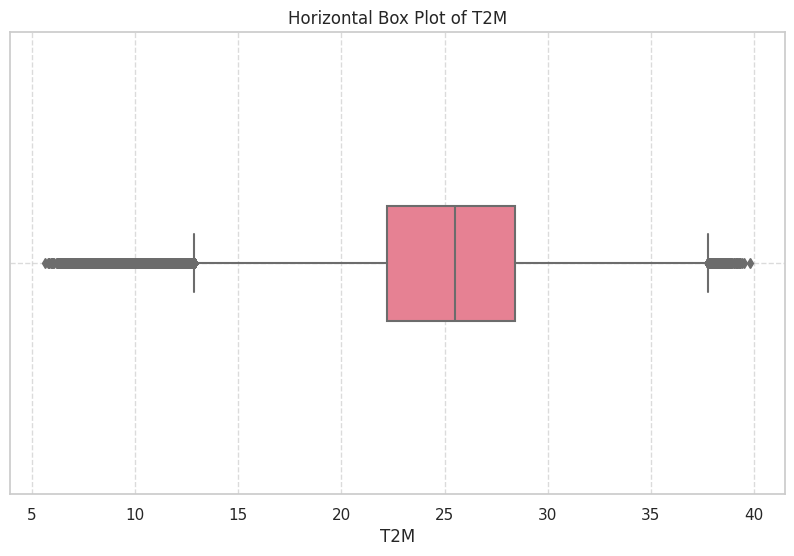

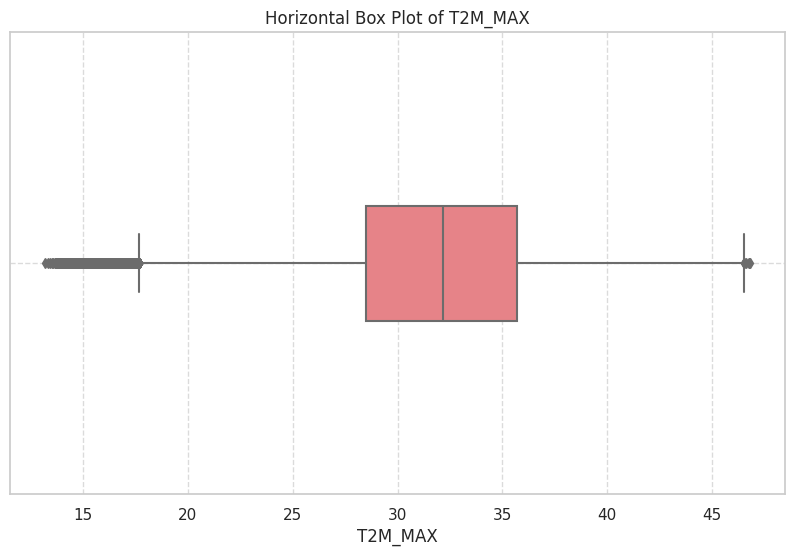

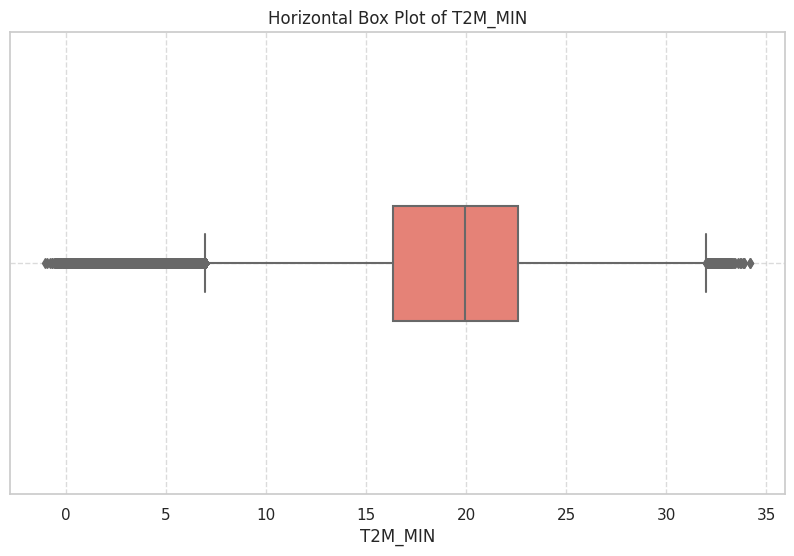

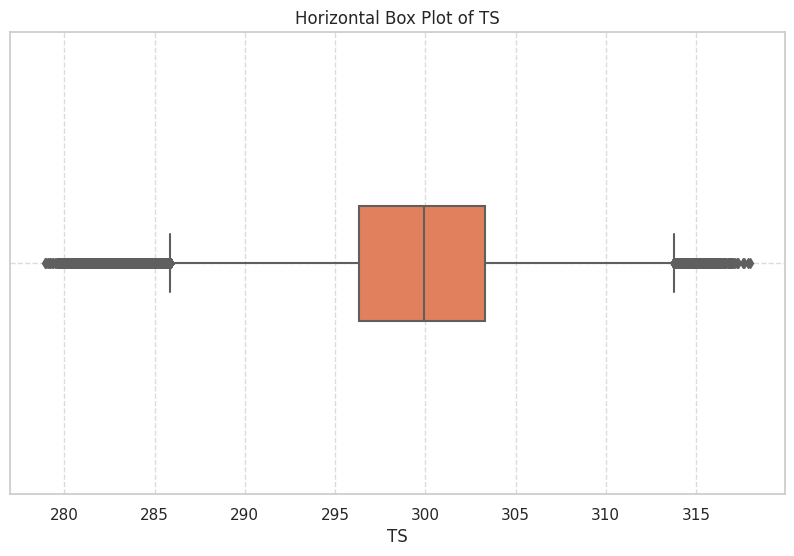

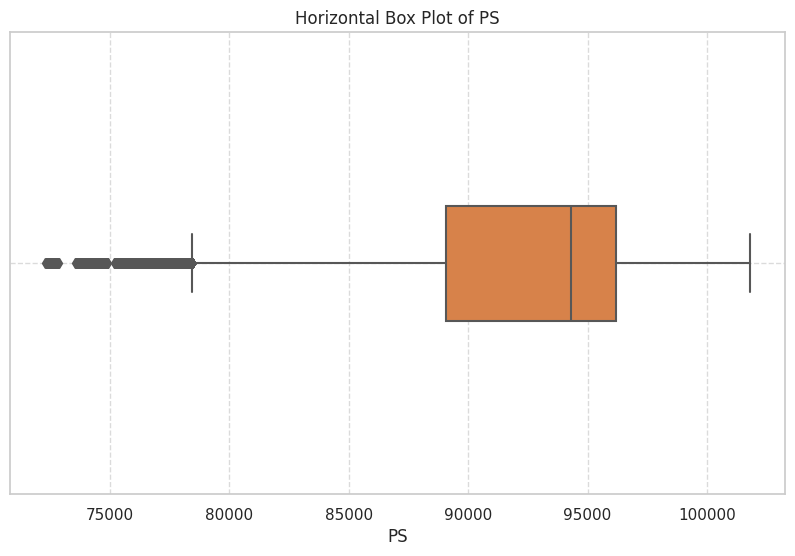

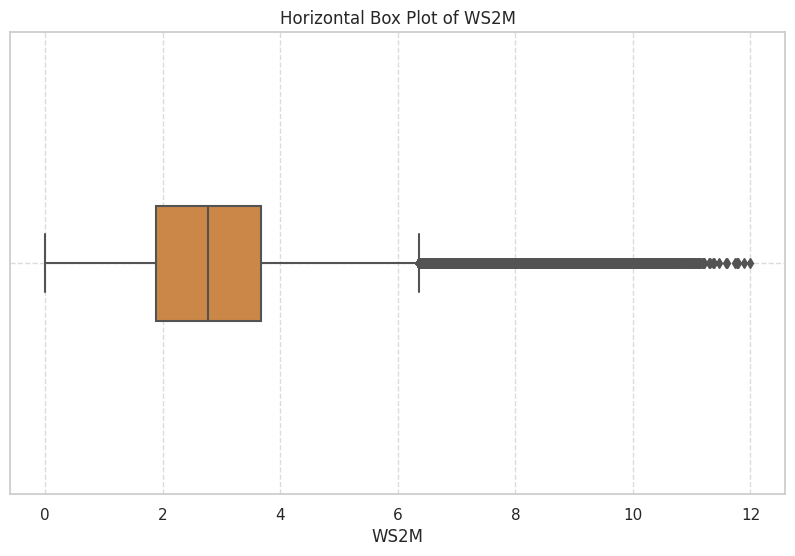

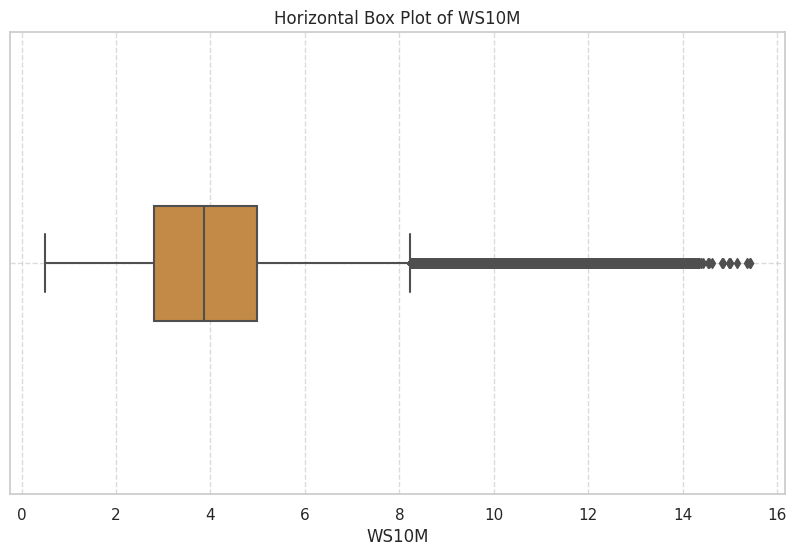

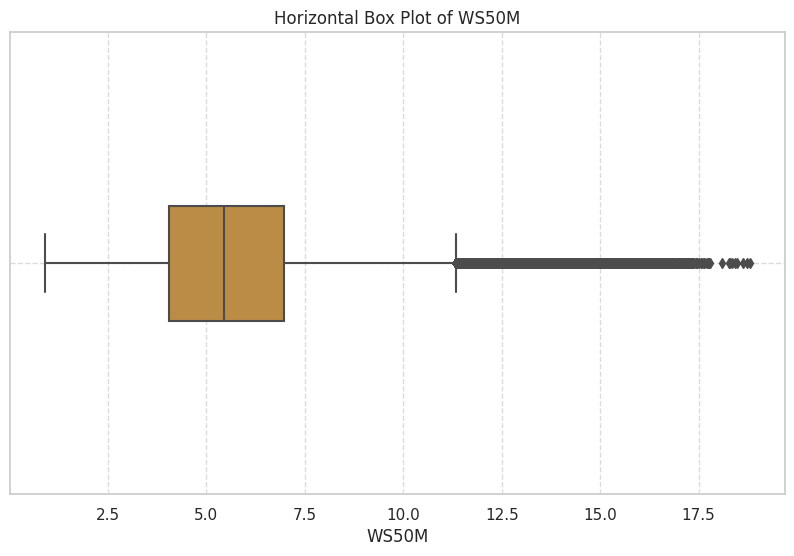

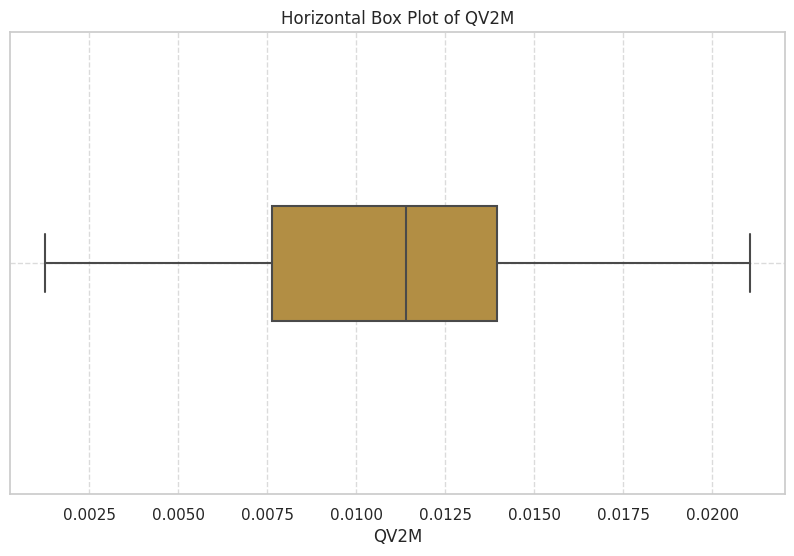

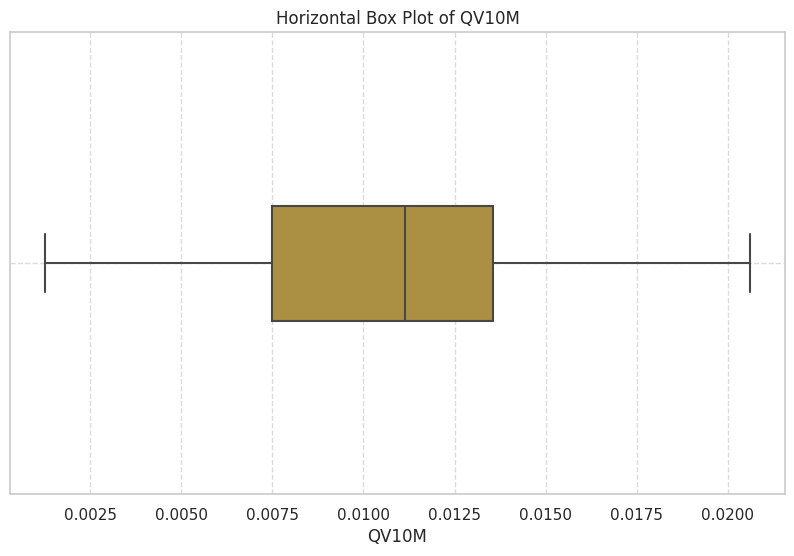

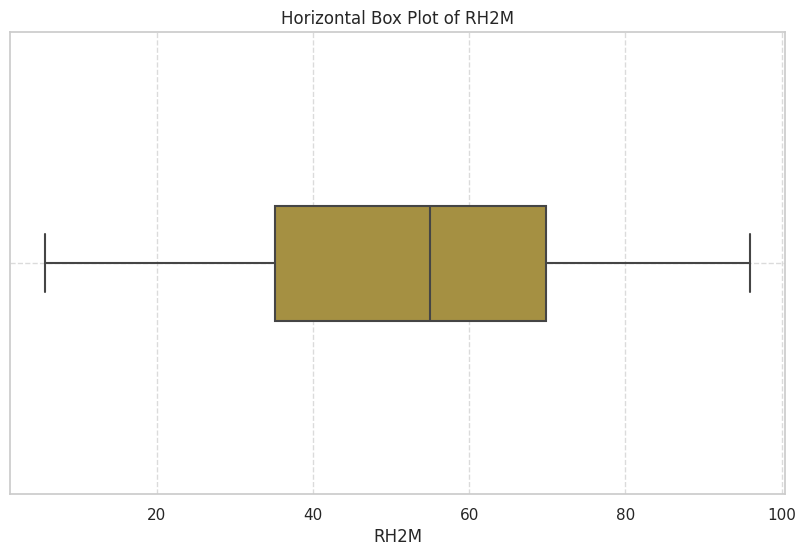

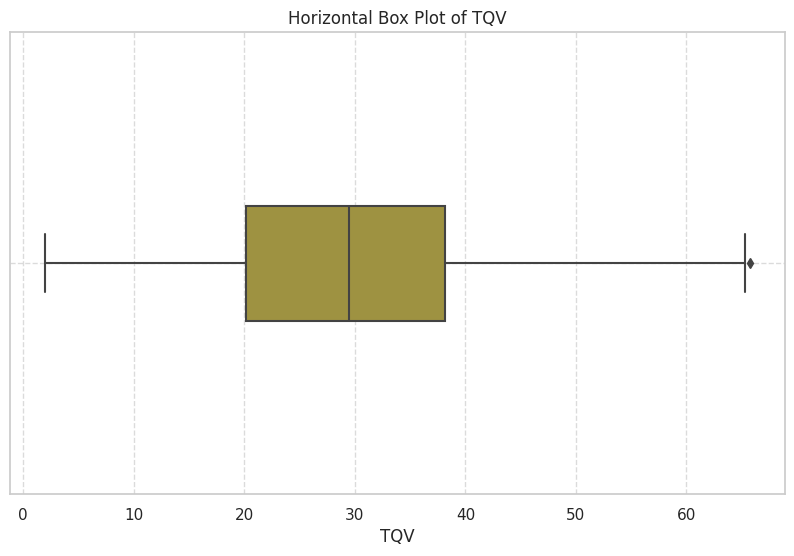

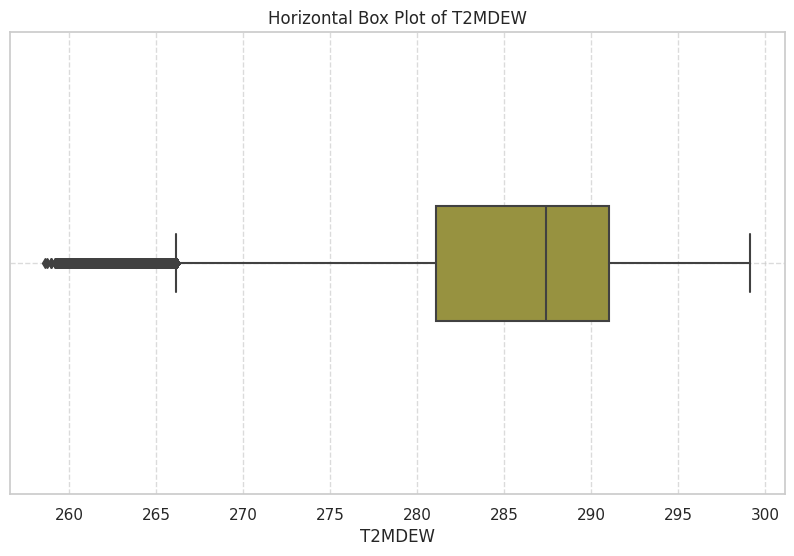

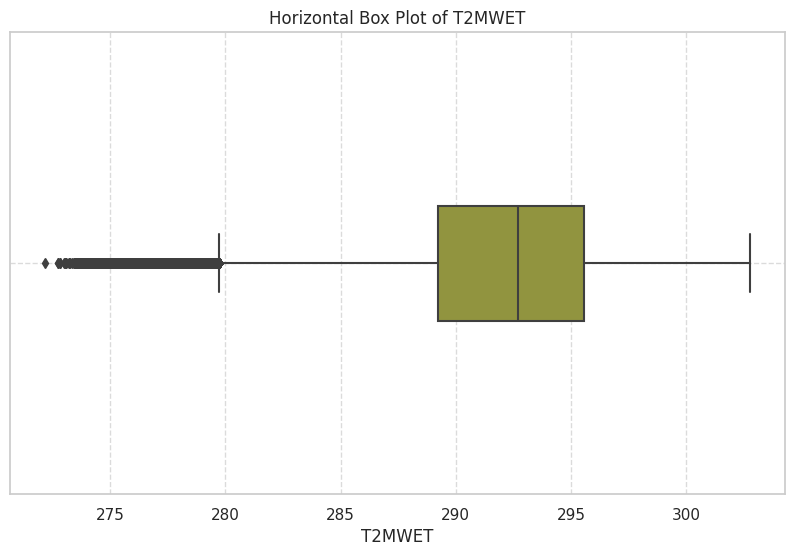

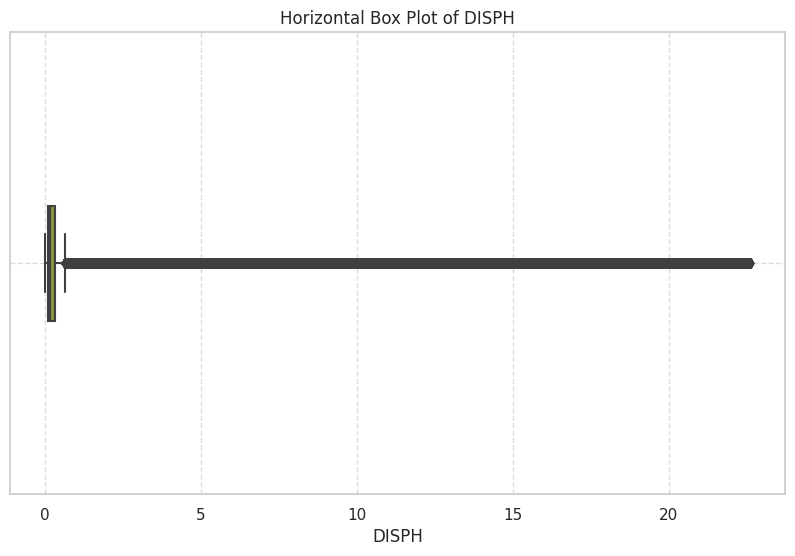

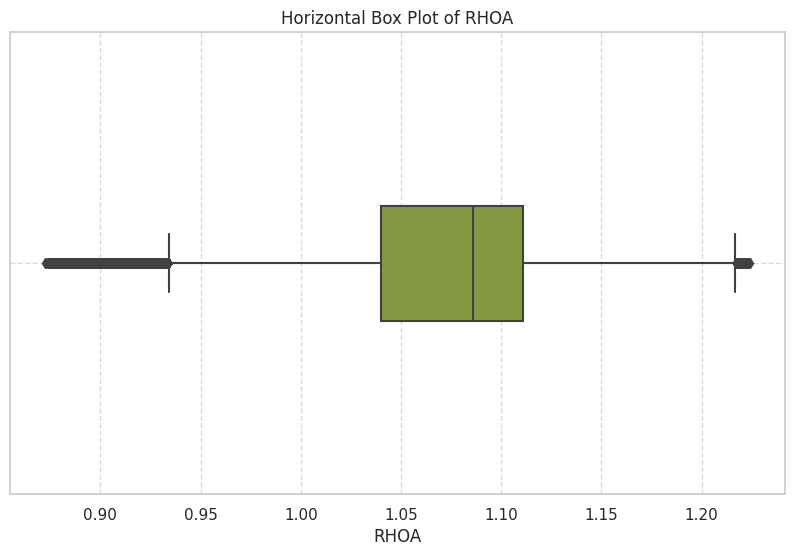

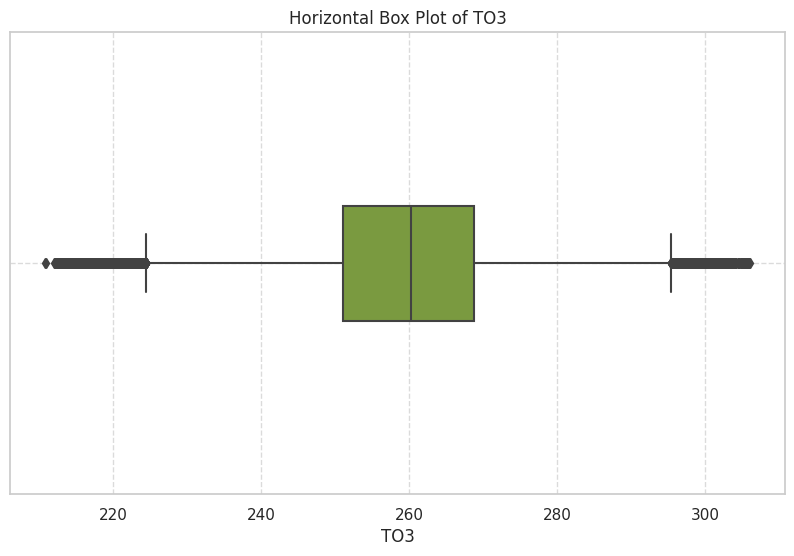

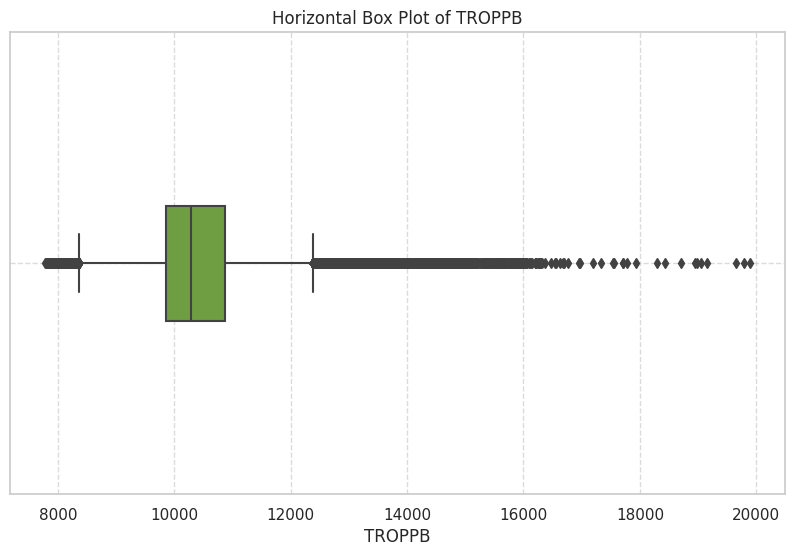

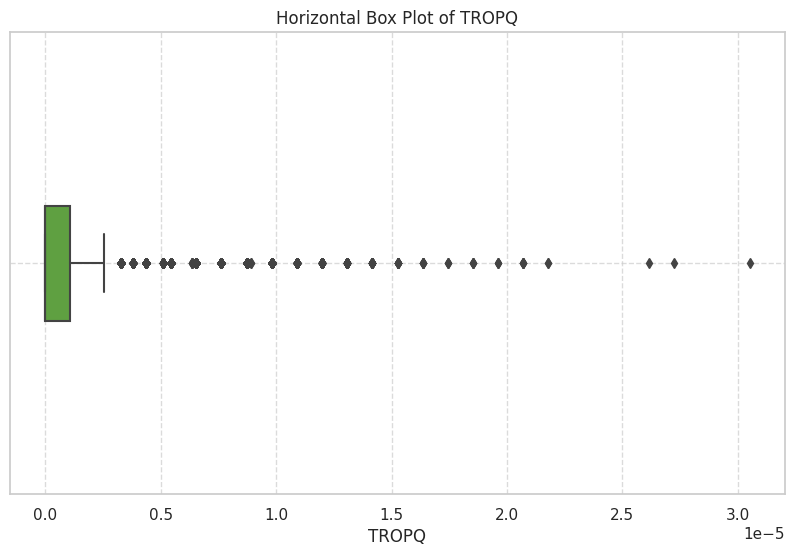

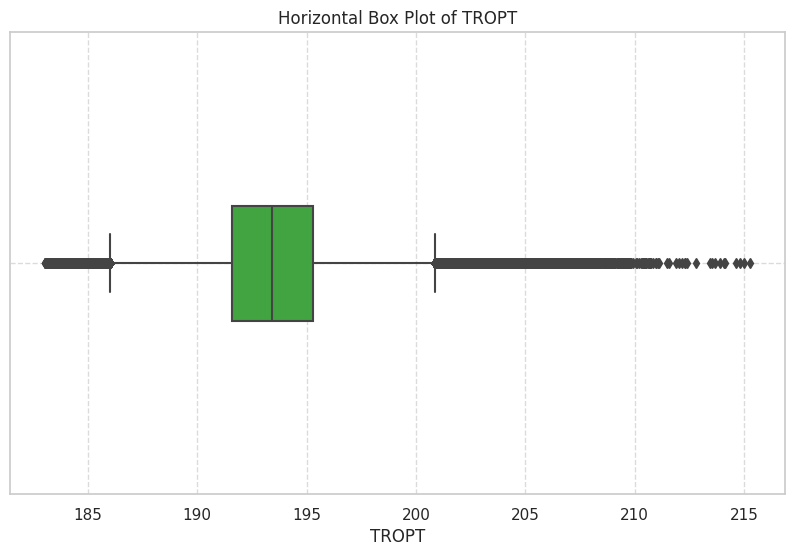

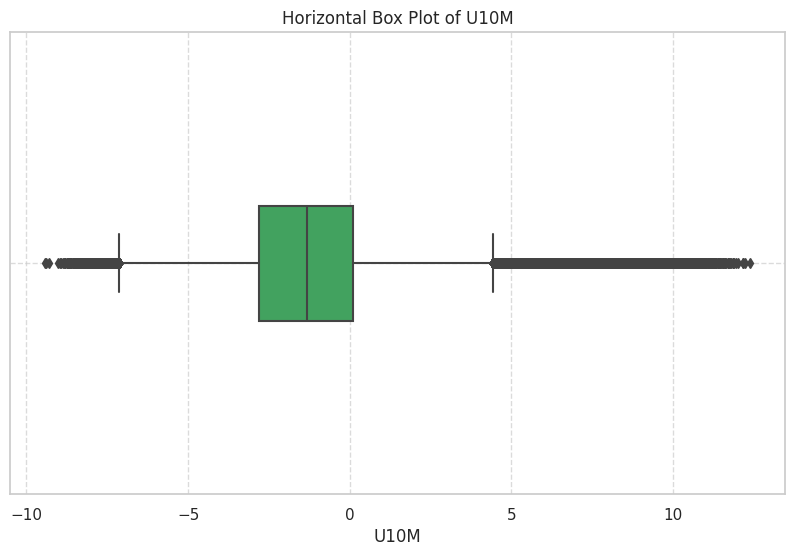

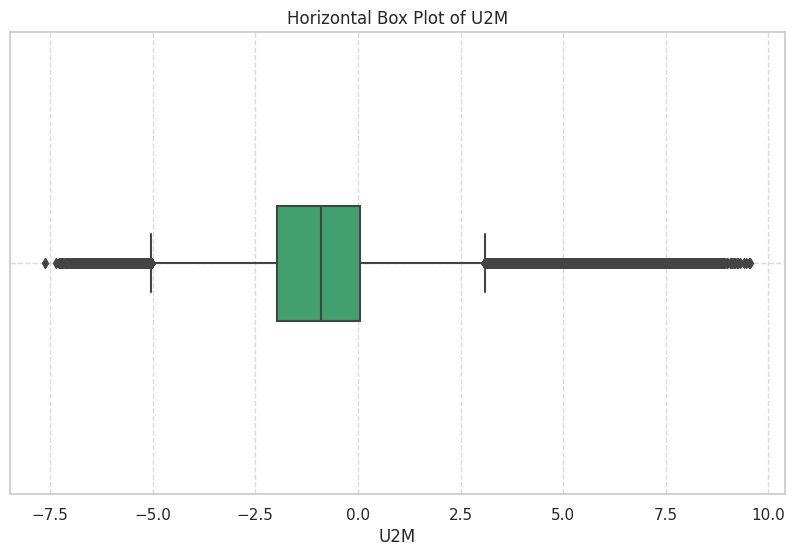

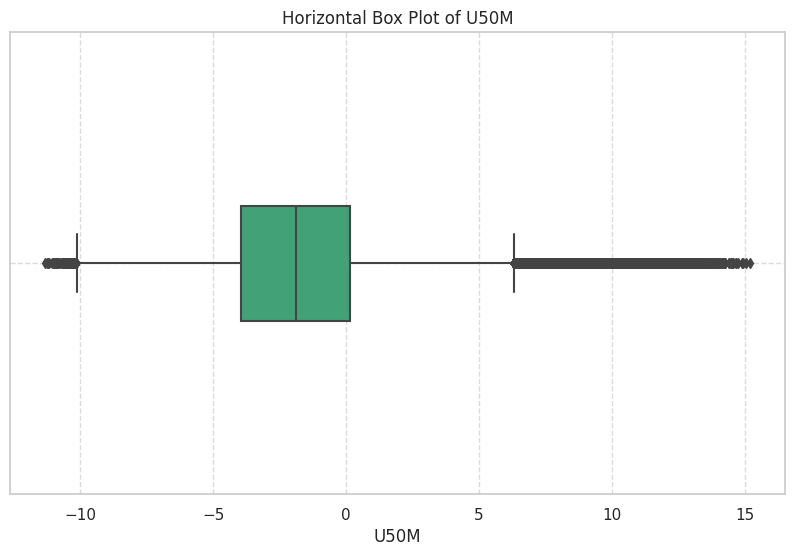

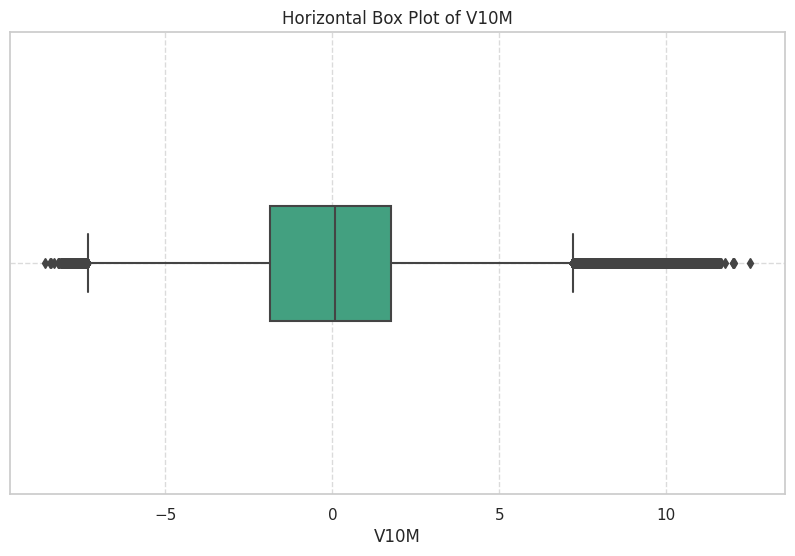

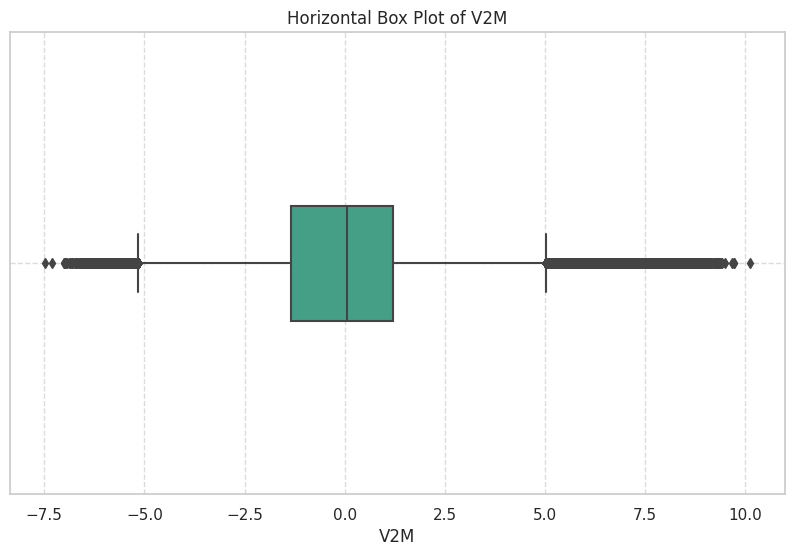

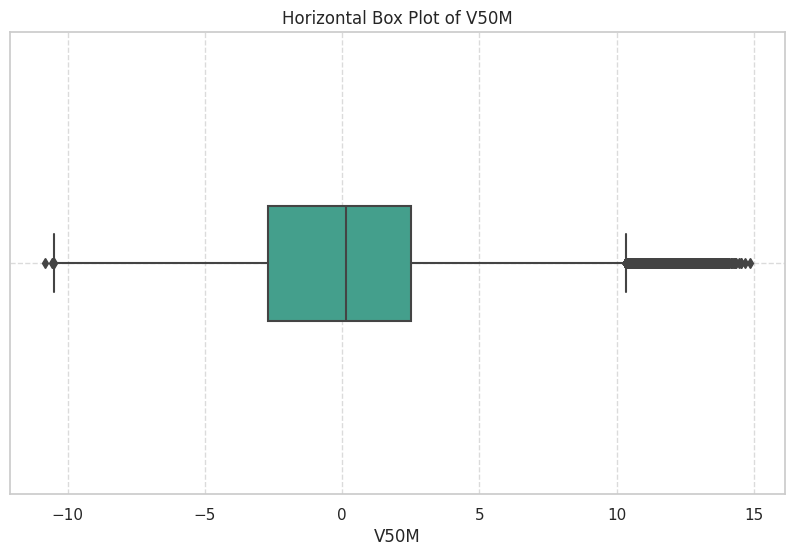

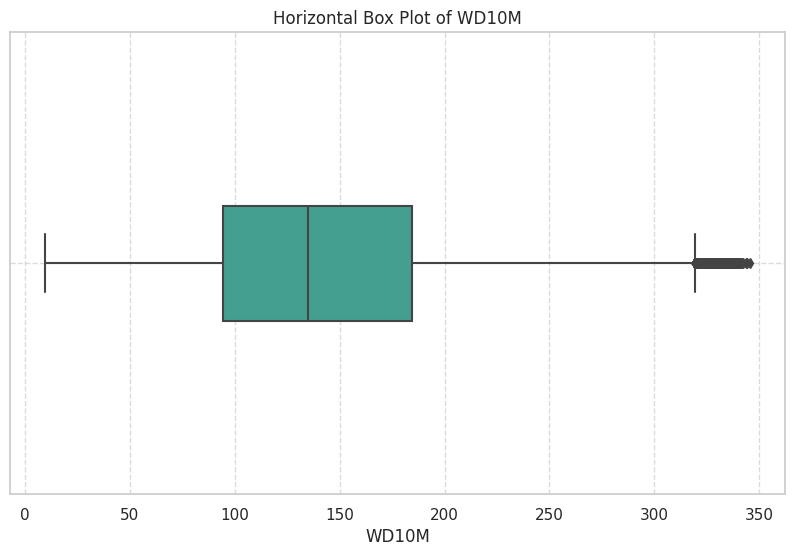

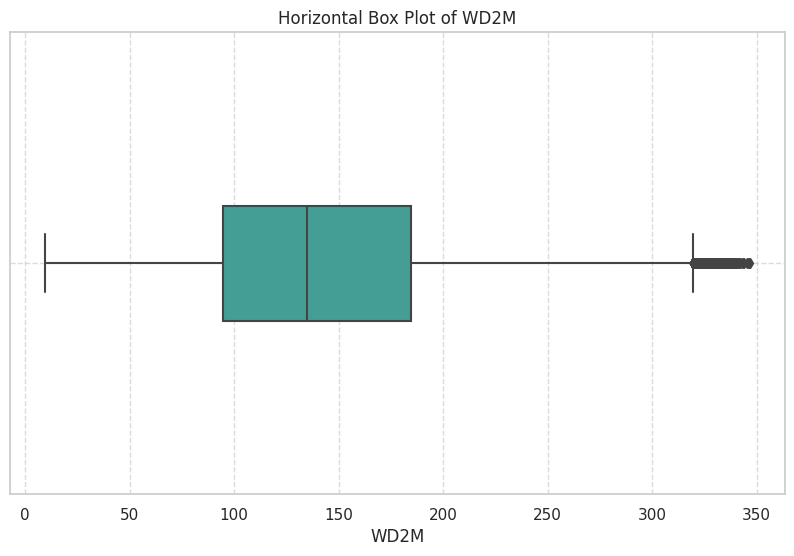

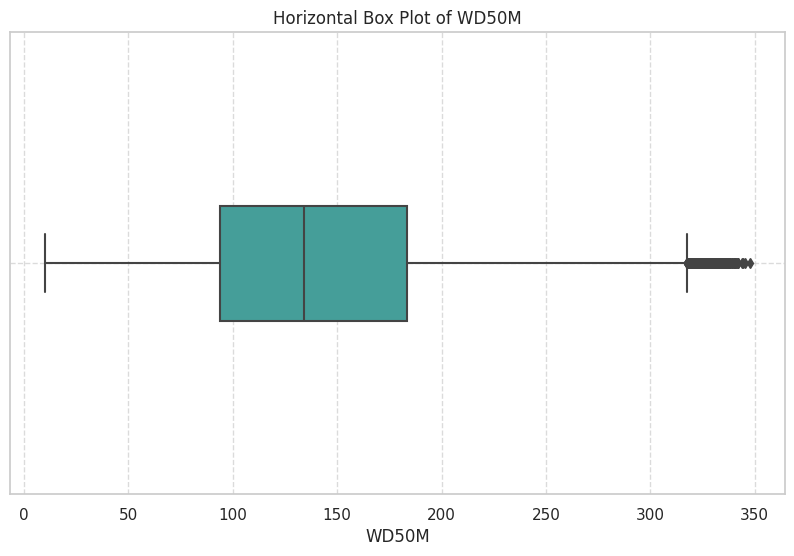

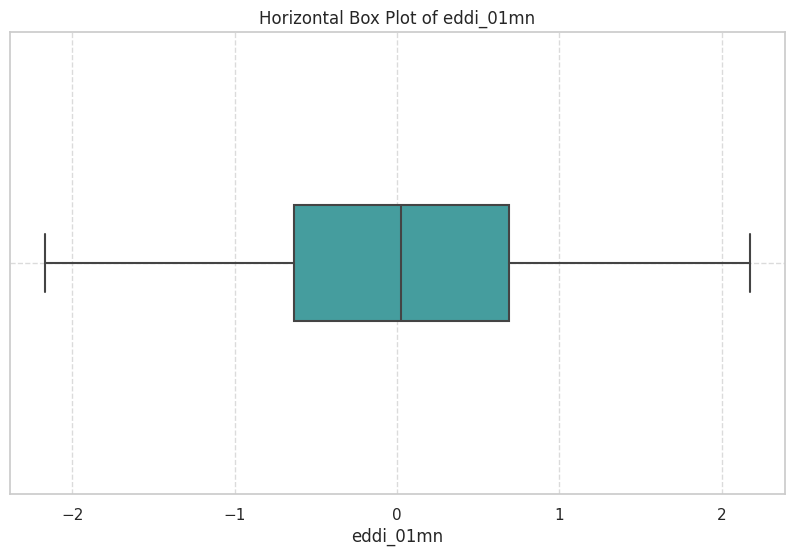

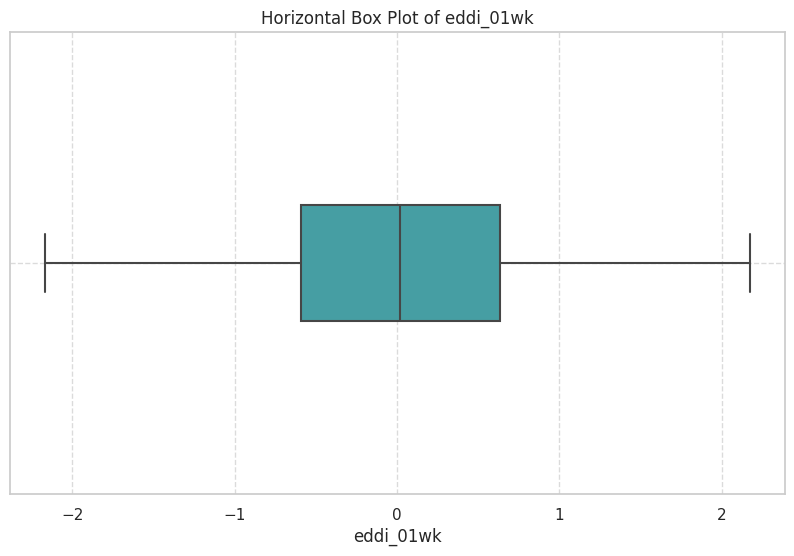

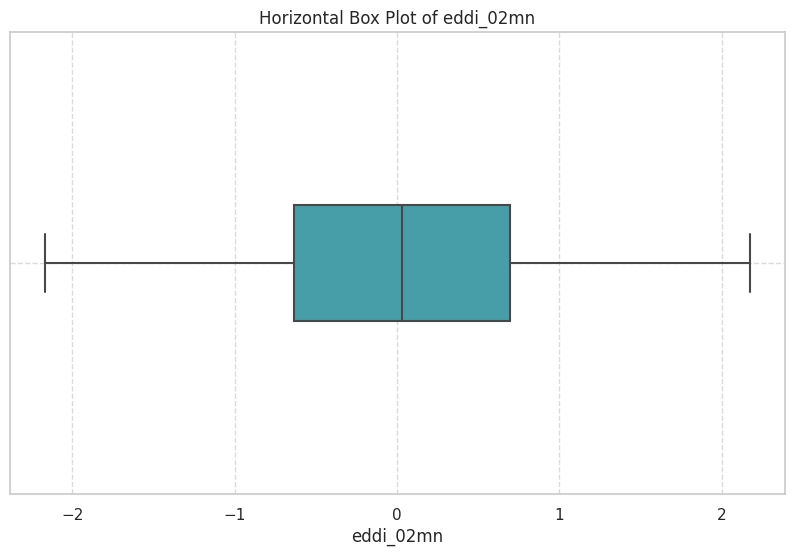

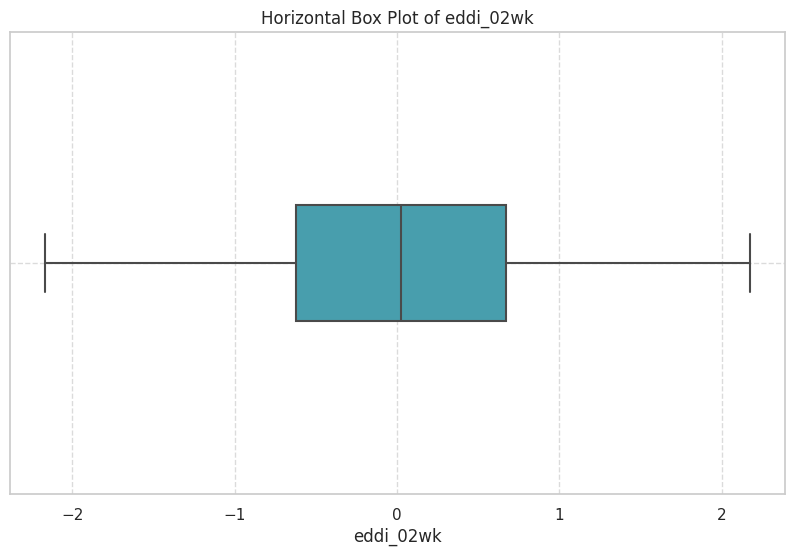

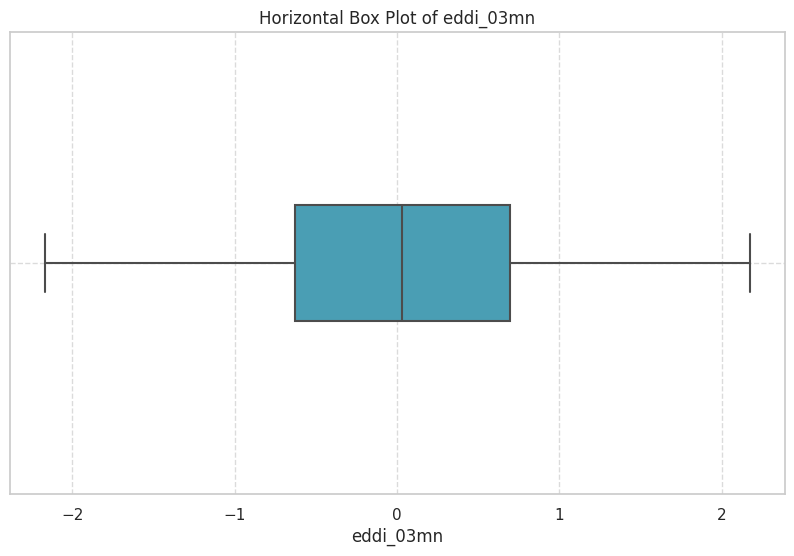

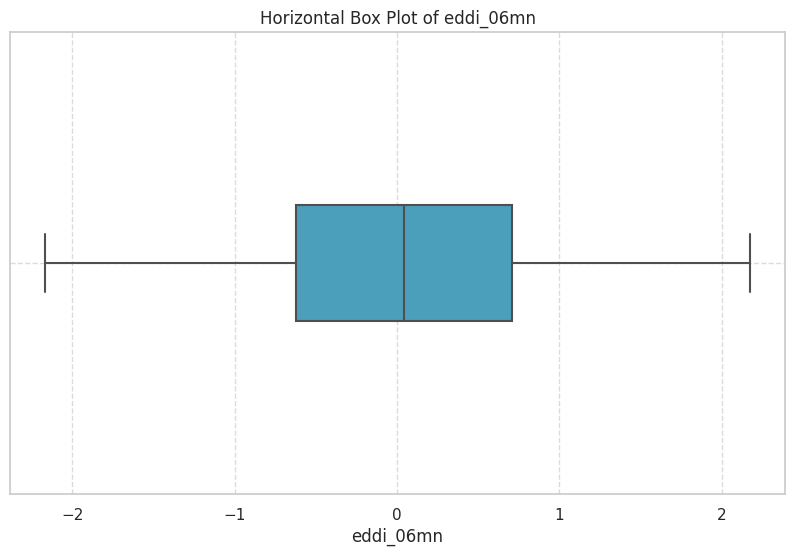

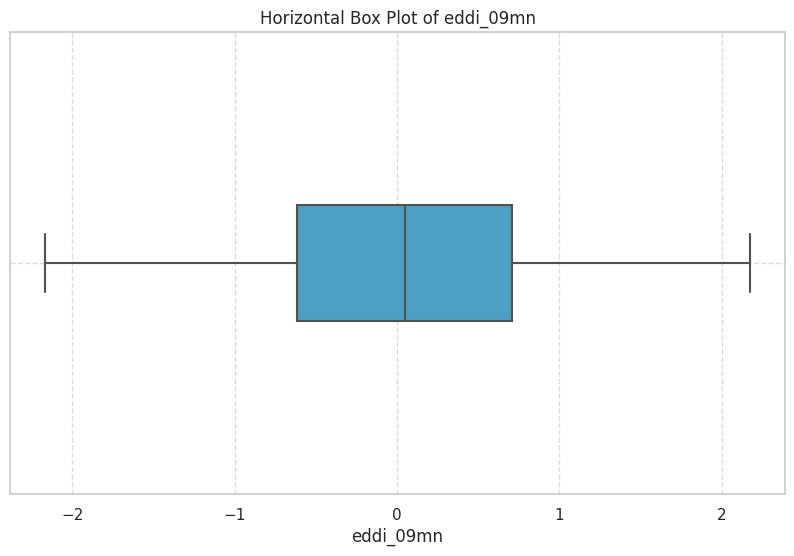

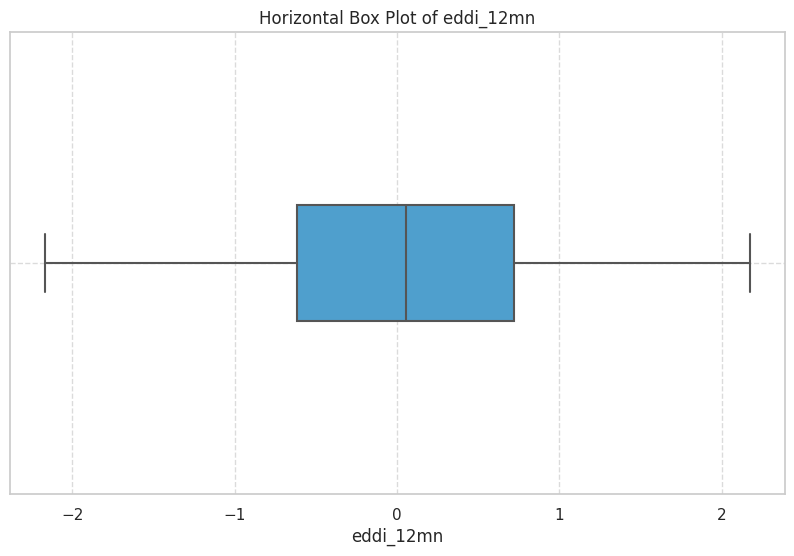

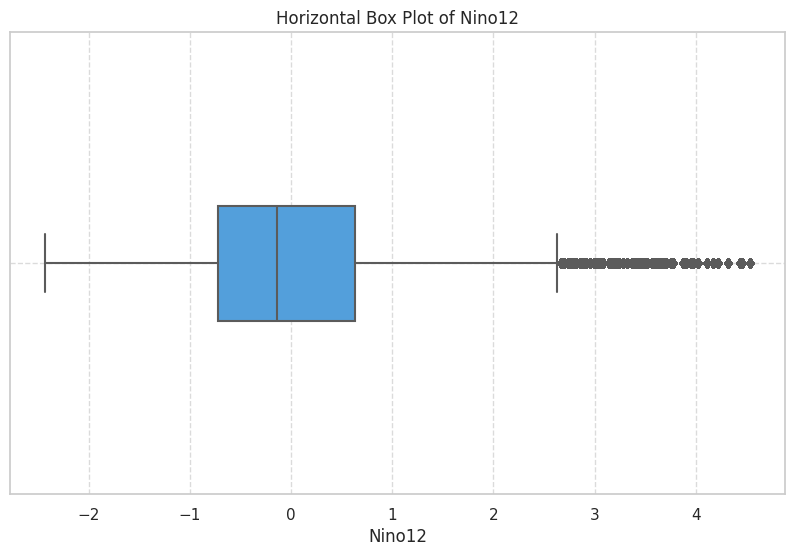

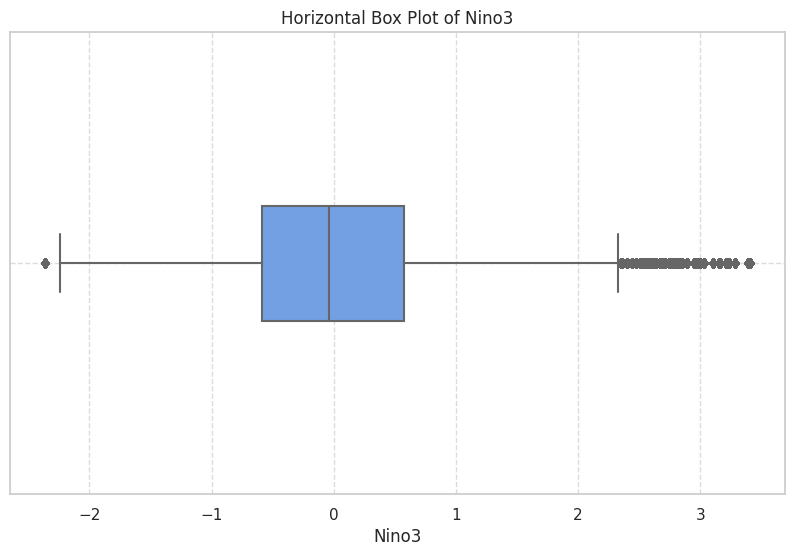

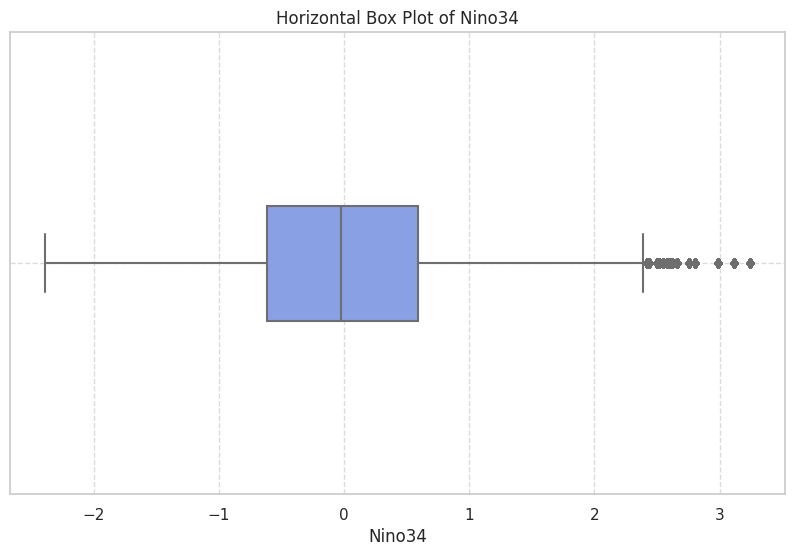

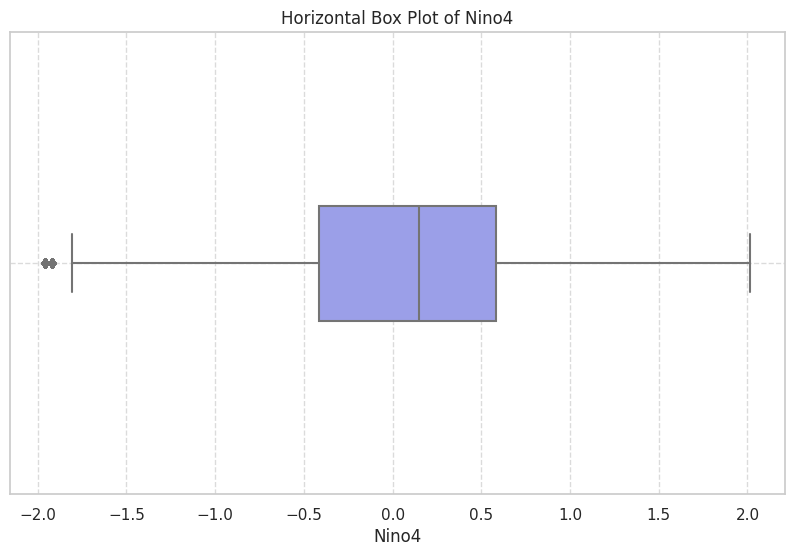

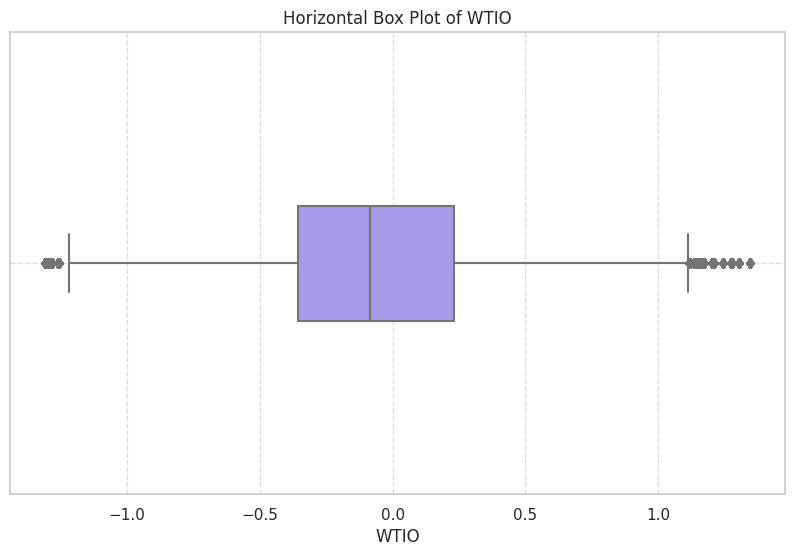

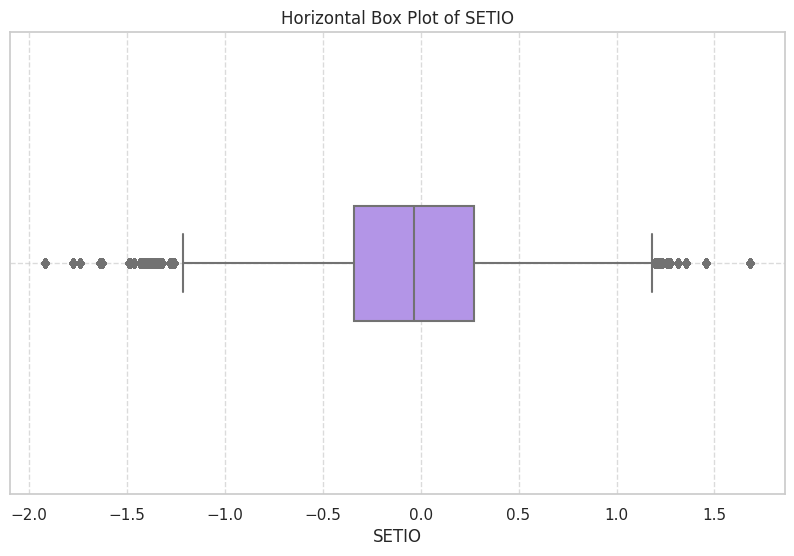

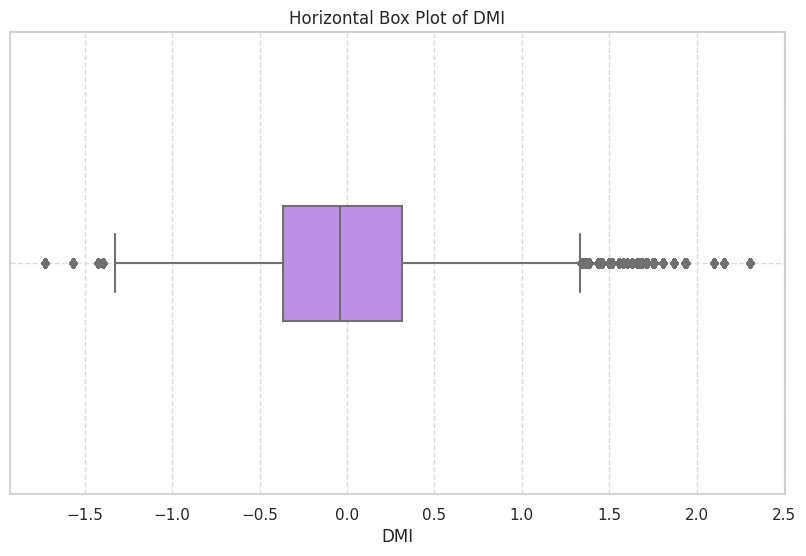

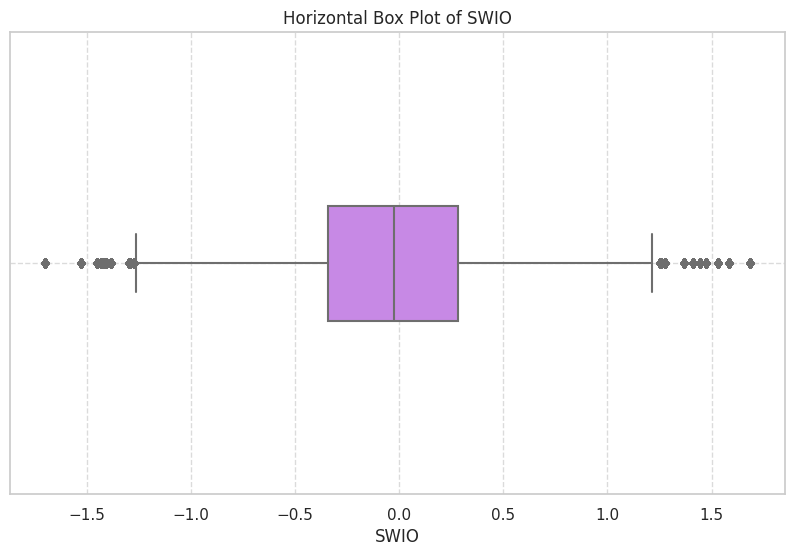

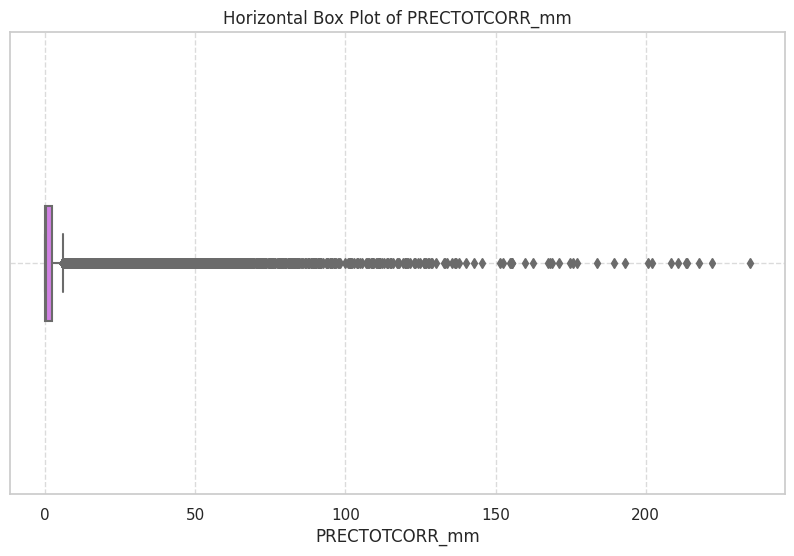

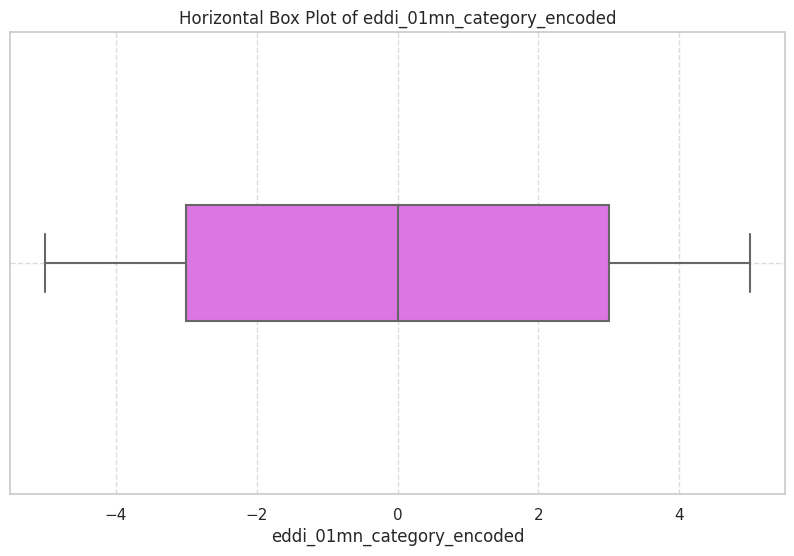

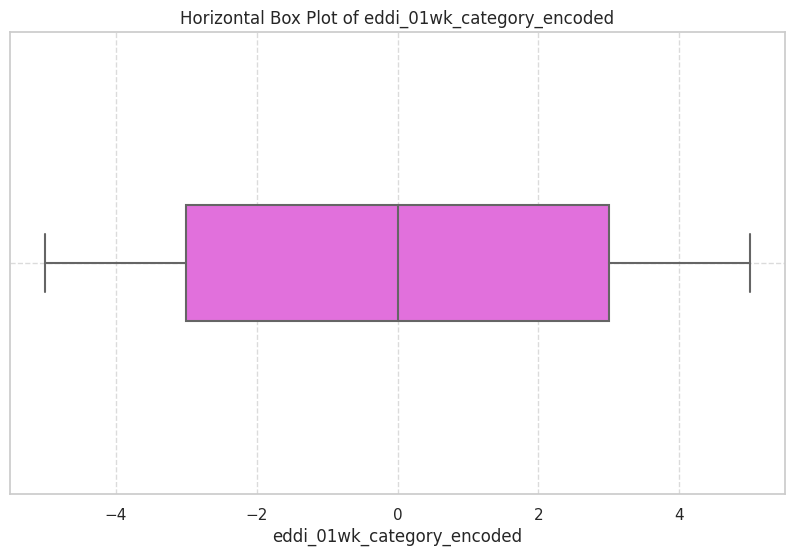

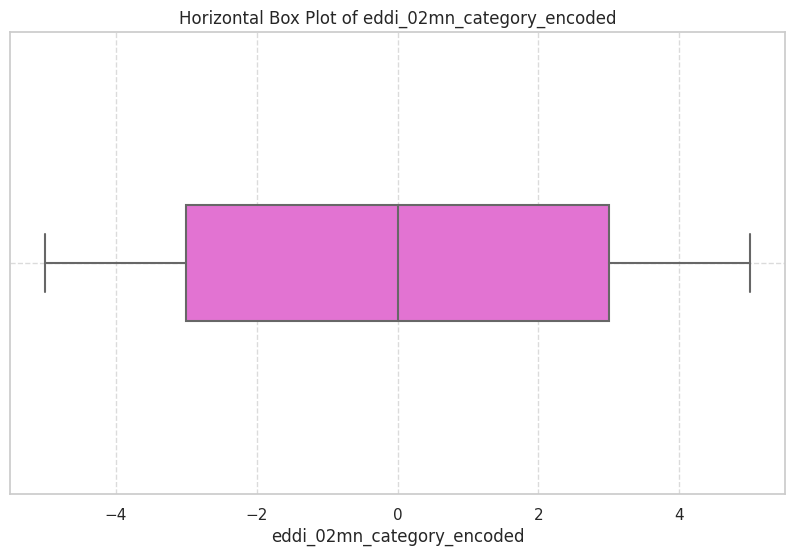

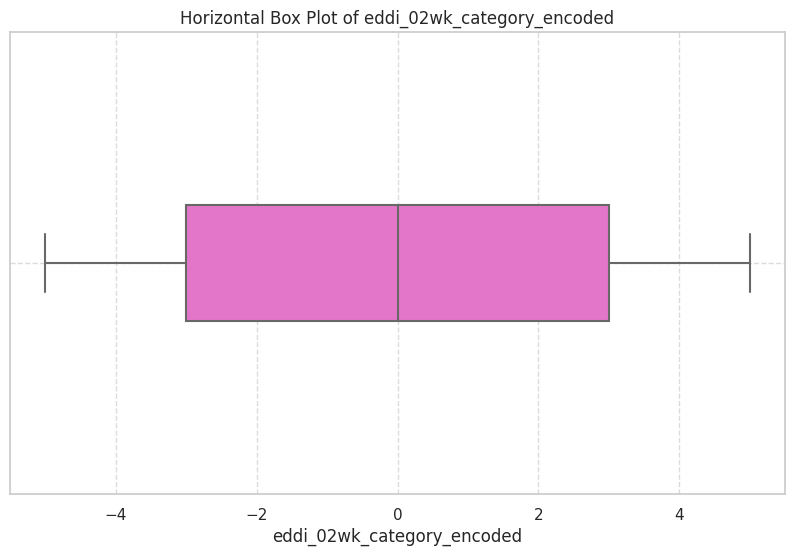

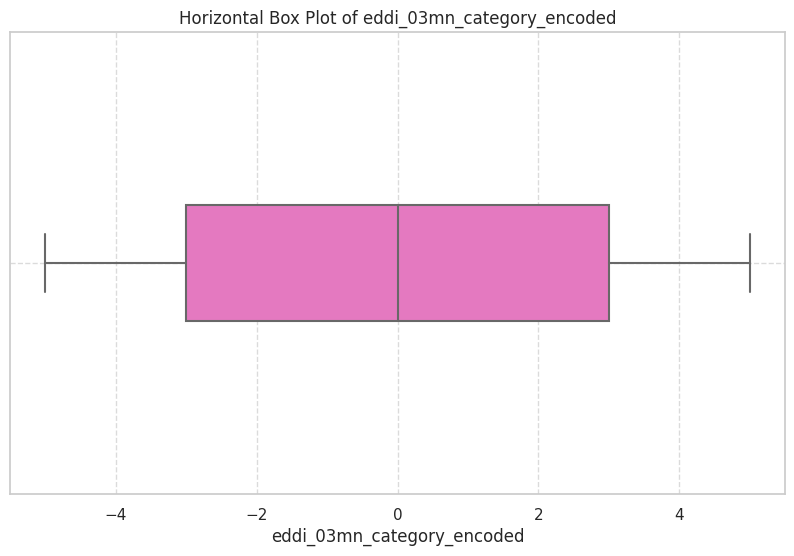

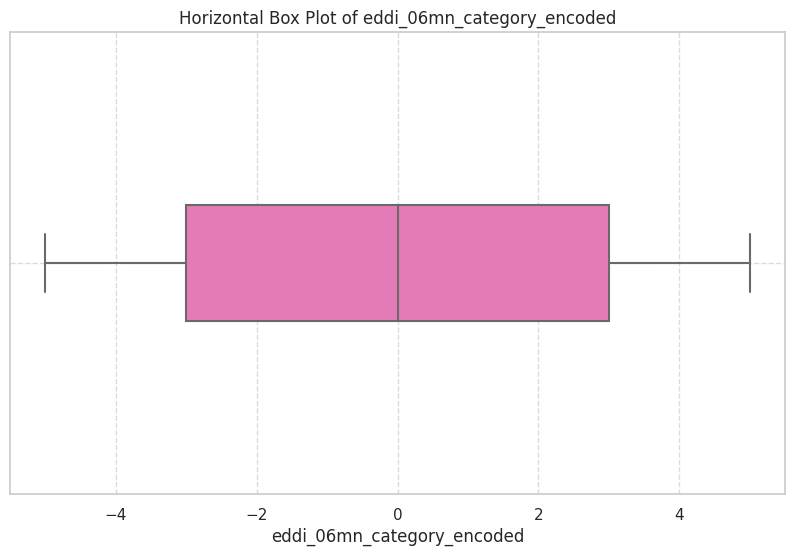

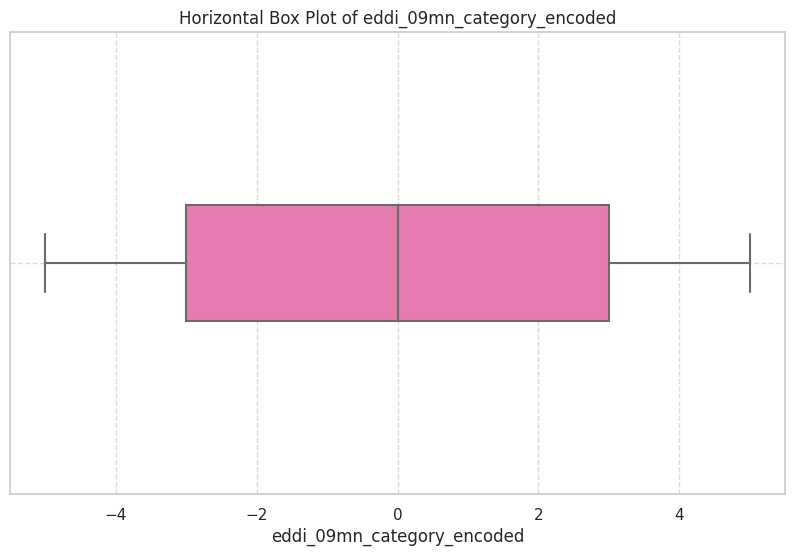

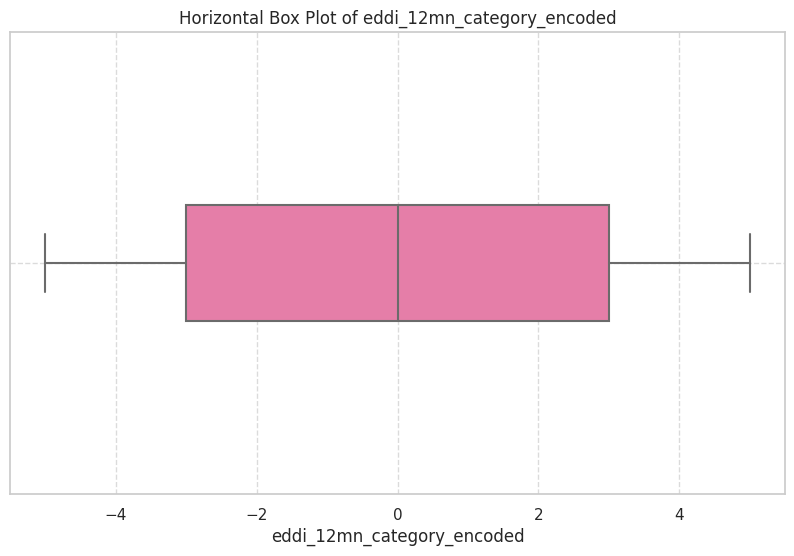

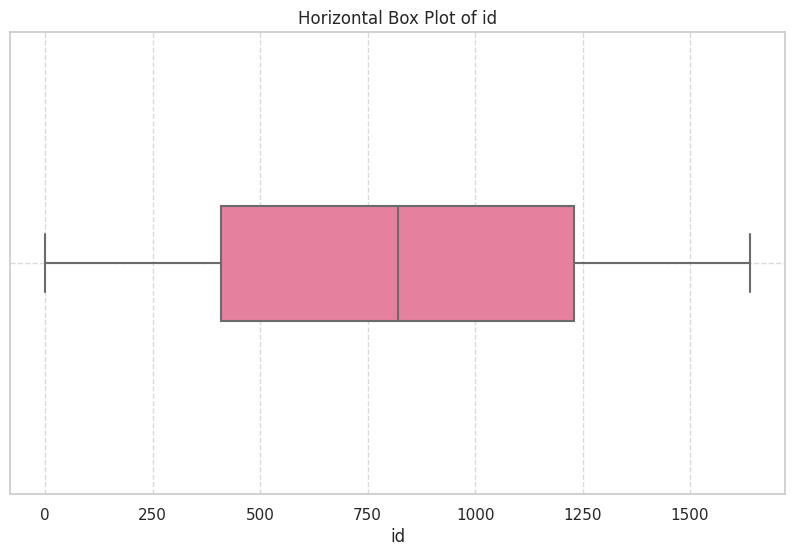

In [23]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots(polars_df, box_width=0.5):
    """
    Plot horizontal box plots for each variable in the Polars DataFrame except 'time', 'lat', and 'lon',
    with an adjustable width for the boxes.

    Parameters:
    - polars_df (pl.DataFrame): The input Polars DataFrame containing the data to be plotted.
    - box_width (float): The width of the box in the box plot. Default is 0.5.

    Returns:
    None, displays the box plots.
    """
    # Set the aesthetic appearance of the plots
    sns.set(style="whitegrid")

    # Get the list of columns to plot, excluding 'time', 'lat', and 'lon'
    columns_to_plot = [col for col in polars_df.columns if col not in ['time', 'lat', 'lon']]

    # Define a color palette
    palette = sns.color_palette("husl", len(columns_to_plot))

    # Loop through each column and create a separate boxplot
    for idx, column in enumerate(columns_to_plot):
        # Selecting the column for visualization
        values = polars_df[column].to_numpy()  # Convert to NumPy array for Matplotlib

        # Creating the horizontal box plot for the current column
        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
        sns.boxplot(x=values, color=palette[idx], width=box_width)  # Use seaborn for a colored boxplot with adjusted width
        plt.xlabel(f'{column}')  # X-axis Label
        plt.title(f'Horizontal Box Plot of {column}')  # Title of the plot
        plt.grid(True, linestyle='--', alpha=0.7)  # Enable grid for better readability
        plt.show()

# Example usage:
plot_boxplots(polars_df, box_width=0.25)


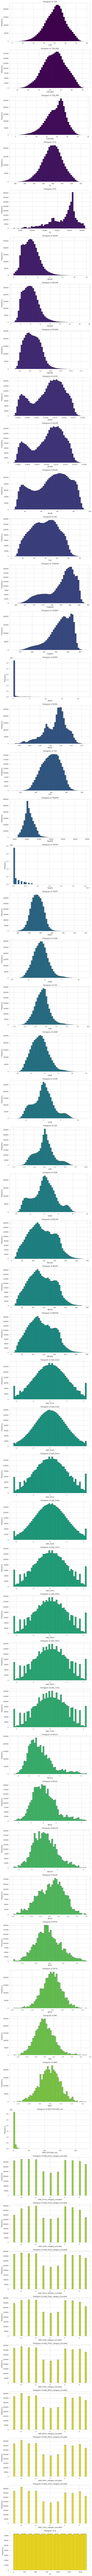

In [24]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_histograms(dataframe: pl.DataFrame, exclude_columns: list = ['time', 'lat', 'lon'], n_bins: int = 50):
    """
    Plot histograms for each column in the DataFrame except the specified columns.

    Parameters:
    - dataframe (pl.DataFrame): The Polars DataFrame containing the data.
    - exclude_columns (list): A list of column names to exclude from histogram plotting.
    - n_bins (int): Number of bins for each histogram.

    This function plots each selected column's histogram in a different color.
    """
    # Selecting the columns that are not in the exclude list
    hist_columns = [col for col in dataframe.columns if col not in exclude_columns]

    # Creating a figure with subplots; adjust the figure size and layout as necessary
    fig, axs = plt.subplots(len(hist_columns), 1, figsize=(10, 5 * len(hist_columns)), tight_layout=True)

    # If there's only one column to plot, axs may not be an array, handle single histogram case
    if len(hist_columns) == 1:
        axs = [axs]

    # Create a colormap
    colors = cm.viridis(np.linspace(0, 1, len(hist_columns)))

    # Plotting histogram for each selected column
    for ax, col, color in zip(axs, hist_columns, colors):
        # Extract the data for the column
        data = dataframe[col].to_numpy()  # Convert to numpy array for compatibility with matplotlib
        
        # Plot the histogram
        ax.hist(data, bins=n_bins, color=color, edgecolor='black')
        
        # Setting the title for each subplot
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    # Display the plots
    plt.show()

# Example of usage:
plot_histograms(polars_df) 


# Correlations

## Correlation between all variables 